In [3]:
import pandas as pd    # for data manipulation and analysis
import numpy as np     # for numerical operations
%matplotlib inline    
import matplotlib.pyplot as plt    # for plotting
import matplotlib.lines as mlines    # for drawing lines on plots
from mpl_toolkits.mplot3d import Axes3D    # for 3D plotting
import seaborn as sns    # for statistical visualization
from sklearn.model_selection import train_test_split, learning_curve    # for splitting data into training and testing sets, and plotting learning curves
from sklearn.metrics import average_precision_score    # for evaluating the model's performance
!pip install xgboost
from xgboost.sklearn import XGBClassifier    # for building a classification model
from xgboost import plot_importance, to_graphviz    # for visualizing the feature importance and the decision tree of the model

     --------------------------------------- 70.9/70.9 MB 20.5 MB/s eta 0:00:00


In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
# import data
data = pd.read_csv('C:/Users/tala_/Desktop/Projects/Predicting Financial Fraud/financial_data.csv')

In [7]:
# take a look at the first 5 rows
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Exploratory Data Analysis - Data Wrangling

In [8]:
# rename columns to ensure consistency
data = data.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [14]:
# Understanding of the shape and type of data
print('There are',data.shape[0],'rows and',data.shape[1],'columns\n')
data.info()
data.describe()

There are 6362620 rows and 11 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [16]:
# Look for null values
data.isnull().values.any()

False

In [20]:
# Explore fraudulent transactions
fraud_types = data.loc[data.isFraud == 1].type.drop_duplicates().values
fraud_transfer = data.loc[(data.isFraud == 1) & (data.type == 'TRANSFER')]
fraud_cashout = data.loc[(data.isFraud == 1) & (data.type == 'CASH_OUT')]

print(f"\nThe types of fraudulent transactions are {list(fraud_types)}")
print(f"\nThe number of fraudulent TRANSFERs = {len(fraud_transfer)}")
print(f"\nThe number of fraudulent CASH_OUTs = {len(fraud_cashout)}")


The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

The number of fraudulent TRANSFERs = 4097

The number of fraudulent CASH_OUTs = 4116


#### Exploring 'isFlaggedFraud'

In [22]:
# Explore what flags a transaction as fraudulent
# Display the type of transactions in which isFlaggedFraud is set
flagged_types = data.loc[data.isFlaggedFraud == 1].type.drop_duplicates().values
print(f"\nThe type of transactions in which isFlaggedFraud is set: {list(flagged_types)}")
# only 'TRANSFER'

# Filter the dataframe to include only transfers
transfer = data.loc[data.type == 'TRANSFER']

# Filter the dataframe to include only flagged and non-flagged transactions
flagged = data.loc[data.isFlaggedFraud == 1]
not_flagged = data.loc[data.isFlaggedFraud == 0]

# Display the minimum amount transacted when isFlaggedFraud is set
print(f"\nMin amount transacted when isFlaggedFraud is set= {flagged.amount.min()}") 

# Display the maximum amount transacted in a transfer where isFlaggedFraud is not set
max_not_flagged = transfer.loc[transfer.isFlaggedFraud == 0].amount.max()
print(f"\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set= {max_not_flagged}") 


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


In [23]:
# oldBalanceDest and newBalanceDest are both 0s when the transaction is flagged, does this determine if a transaction
# should be flagged?
flagged

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


In [26]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0: {}'.\
format(len(transfer.loc[(transfer.isFlaggedFraud == 0) & \
(transfer.oldBalanceDest == 0) & (transfer.newBalanceDest == 0)]))) 


The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158


In [28]:
# Filter the dataframe to include only flagged transfers
flagged_transfers = data.loc[(data.isFlaggedFraud == 1) & (data.type == 'TRANSFER')]

# Display the minimum and maximum oldBalanceOrig for flagged transfers
flagged_min = round(flagged_transfers.oldBalanceOrig.min())
flagged_max = round(flagged_transfers.oldBalanceOrig.max())
print(f"\nMin, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [{flagged_min}, {flagged_max}]")

# Filter the dataframe to include only non-flagged transfers where oldBalanceOrig = newBalanceOrig
same_orig_balance = data.loc[(data.isFlaggedFraud == 0) & (data.type == 'TRANSFER') & (data.oldBalanceOrig == data.newBalanceOrig)]

# Display the minimum and maximum oldBalanceOrig for non-flagged transfers where oldBalanceOrig = newBalanceOrig
not_flagged_min = same_orig_balance.oldBalanceOrig.min()
not_flagged_max = round(same_orig_balance.oldBalanceOrig.max())
print(f"\nMin, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [{not_flagged_min}, {not_flagged_max}]")


Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]

Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668]


In [30]:
# Check if originators of flagged transactions have transacted more than once
flagged_originators = flagged.nameOrig
not_flagged_originators = pd.concat([not_flagged.nameOrig, not_flagged.nameDest])
originators_more_than_once = flagged_originators.isin(not_flagged_originators).any()
print(f"\nHave originators of transactions flagged as fraud transacted more than once? {originators_more_than_once}")

# Check if destinations for flagged transactions have initiated other transactions
flagged_destinations = flagged.nameDest
not_flagged_origins = not_flagged.nameOrig
destinations_initiated_transactions = flagged_destinations.isin(not_flagged_origins).any()
print(f"\nHave destinations for transactions flagged as fraud initiated other transactions? {destinations_initiated_transactions}")

# Check how many destination accounts of flagged transactions have been destinations more than once
flagged_destinations_more_than_once = sum(flagged.nameDest.isin(not_flagged.nameDest))
print(f"\nHow many destination accounts of transactions flagged as fraud have been destination accounts more than once?: {flagged_destinations_more_than_once}")



Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


#### Conclusion </br>
* 'isFlaggedFraud' only occurs 16 times. 
* It is inconsistent with its meaning (isFlagged == 1 if amount > 200,000) since we observed a minimum amount of transaction of 92445516.64 that was not flagged. 
* Although oldBalanceDest and newBalanceDest are always 0 when isFlaggedFraud = 1, this can be seen 4158 times in unflagged data too.
* The old balance from the originated user cannot determine flagging either, as its minimum and maximum values overlap with flagged and unflagged transactions.
* A customer transacting more than once is also uncorrelated whether they're flagged or not. Originators of transactions that have isFlaggedFraud set have transacted only once, and only 2 destination accounts that were flagged transacted more than once.
#### We conclude that this variable is meaningless and uncorrelated with any of our data, so it can be removed.

#### Exploring merchant accounts ('M' in 'nameOrig')

In [40]:
# Group the dataframe by 'nameDest' and 'type' columns and count the number of transactions for each group
dest_transactions = data.groupby(['nameDest', 'type']).size().reset_index(name='count')

# Filter the groups where 'nameDest' starts with 'M'
m_destinations = dest_transactions[dest_transactions.nameDest.str.startswith('M')]

# Display the number of transactions for each 'type' within the groups
result = m_destinations.groupby('type')['count'].sum()
print(result)

type
PAYMENT    2151495
Name: count, dtype: int64


In [43]:
# Group the dataframe by 'nameOrig' and 'type' columns and count the number of transactions for each group
orig_transactions = data.groupby(['nameOrig', 'type']).size().reset_index(name='count')

# Filter the groups where 'nameOrig' starts with 'M'
m_orig = orig_transactions[orig_transactions.nameOrig.str.startswith('M')]

# Display the number of transactions for each 'type' within the groups
result = m_orig.groupby('type')['count'].sum()
print(result)

Series([], Name: count, dtype: int64)


#### Conclusion: Merchants have only been destination accounts and their only transaction method was 'PAYMENT'. They have not been original transactors. This data is uncorrelated and can be removed

#### Data Cleaning

In [53]:
# Fraud only occurs in 'TRANSFER' and 'CASH OUT'
X = data.loc[(data.type=='TRANSFER') | (data.type == 'CASH_OUT')]

In [54]:
randomState = 5
np.random.seed(randomState)

In [55]:
# set target variable and remove it from predictor df
Y = X['isFraud']
del X['isFraud']

In [57]:
# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

In [58]:
# Binary Encoding of transaction type
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

#### Explore fraudulent and non-fraudulent transactions where oldBalanceDest and newBalanceDest = 0

In [59]:
# separate fraudulent and non-fraudulent transactions
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

# calculate the fraction of fraudulent transactions with non-zero amount but 
# zero oldBalanceDest and newBalanceDest
fraud_fraction = len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
                                (Xfraud.newBalanceDest == 0) & \
                                (Xfraud.amount != 0)]) / len(Xfraud)
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(fraud_fraction))

# calculate the fraction of non-fraudulent transactions with non-zero amount but 
# zero oldBalanceDest and newBalanceDest
nonfraud_fraction = len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
                                      (XnonFraud.newBalanceDest == 0) & \
                                      (XnonFraud.amount != 0)]) / len(XnonFraud)
print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(nonfraud_fraction))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


#### Conclusion: such transactions occur more in fraudulent transactions (~ 50%) compared to non-fraudulent (~0.06%)

In [60]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

In [61]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

#### Feature Engineering

In [62]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

#### Data Visualization

In [63]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

C:\Users\tala_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


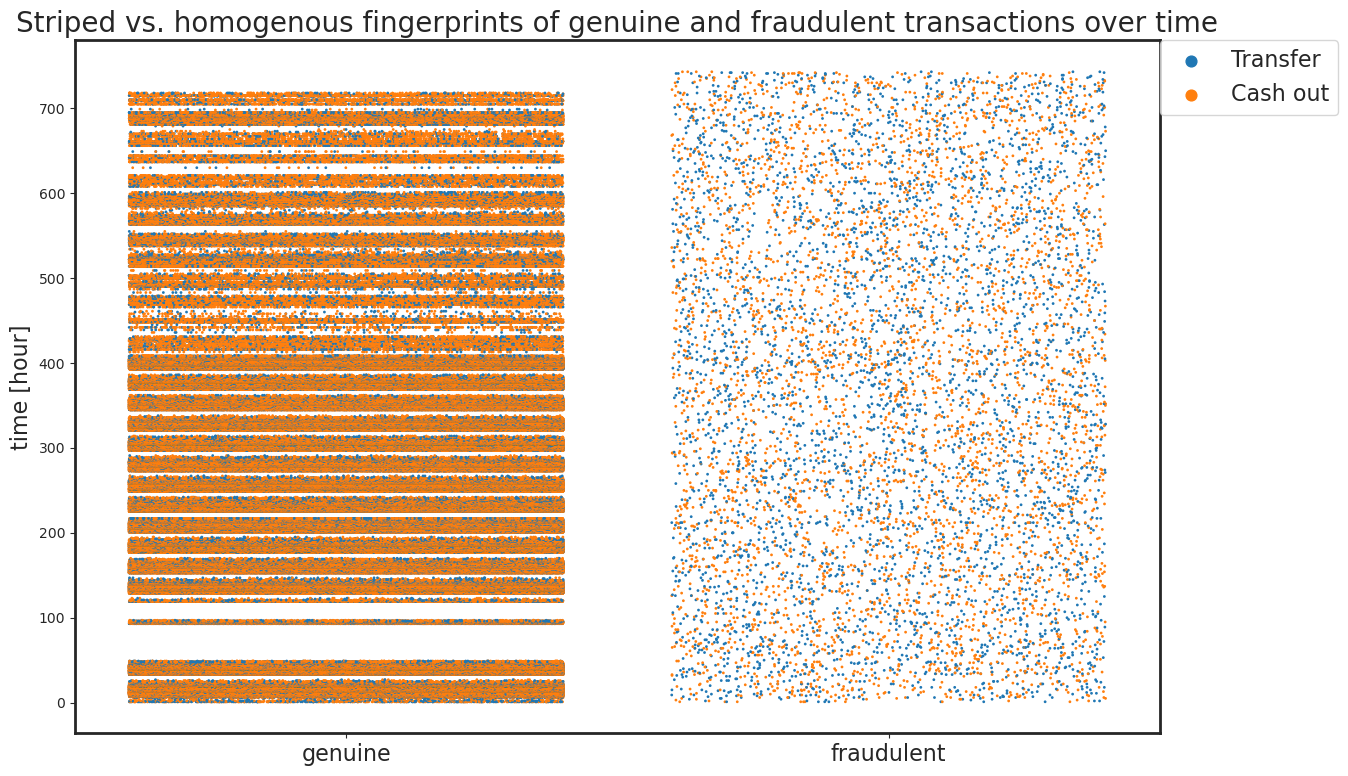

In [64]:
# Dispersion over time
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

C:\Users\tala_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


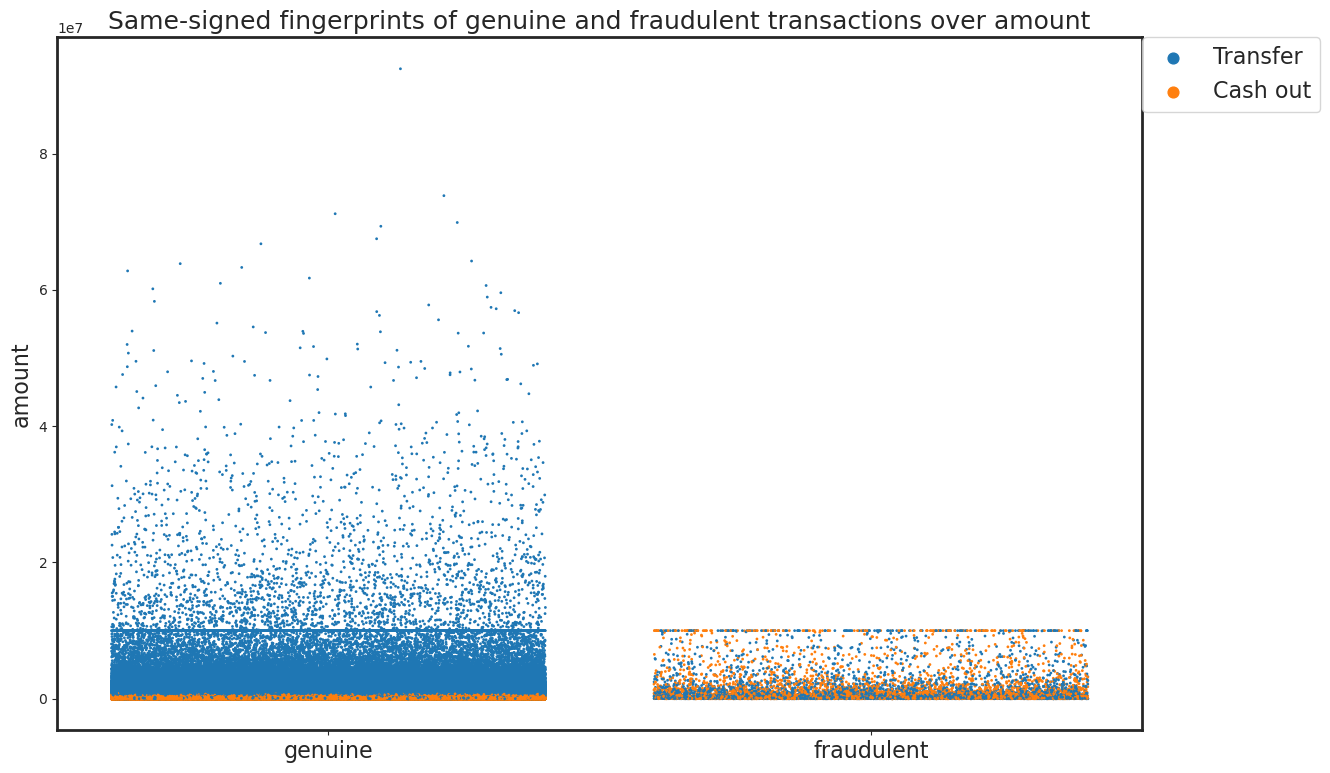

In [65]:
# Dispersion over amount
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

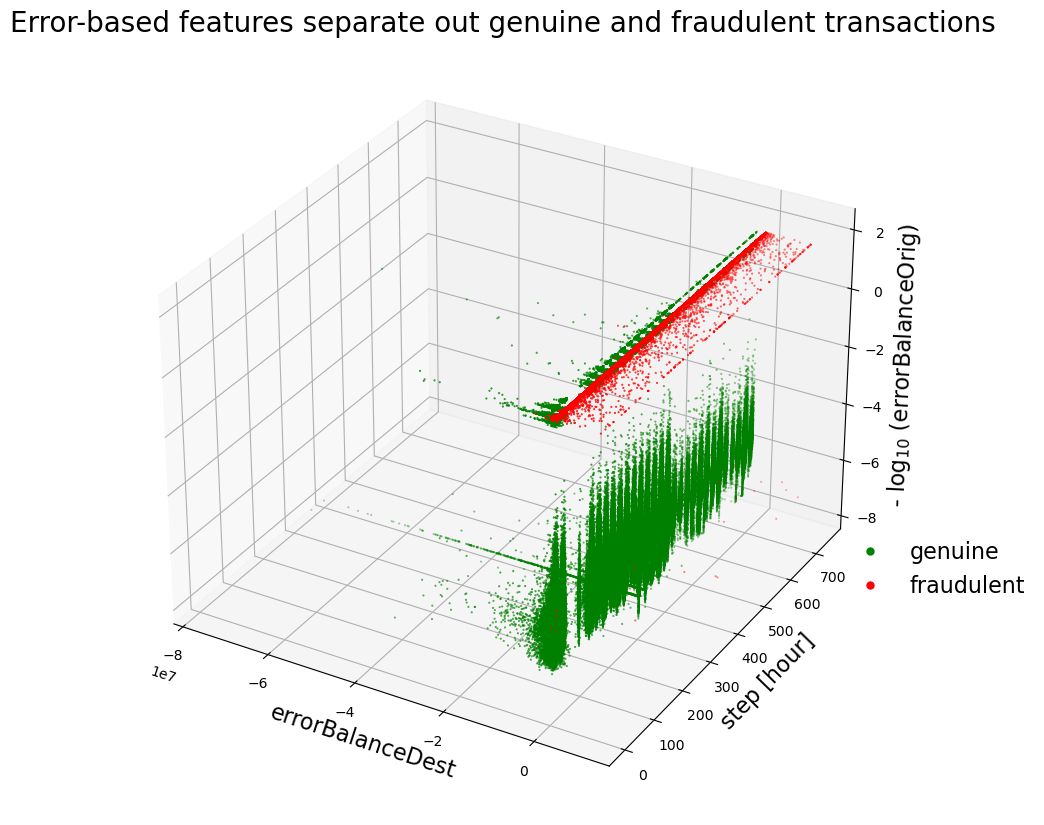

In [66]:
# Separating out genuine from fraudulent transactions
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

genuine_x = X.loc[Y == 0, x][:limit]
genuine_y = X.loc[Y == 0, y][:limit]
genuine_z = -np.log10(X.loc[Y == 0, z][:limit] + zOffset)
fraud_x = X.loc[Y == 1, x][:limit]
fraud_y = X.loc[Y == 1, y][:limit]
fraud_z = -np.log10(X.loc[Y == 1, z][:limit] + zOffset)

ax.scatter(genuine_x, genuine_y, genuine_z, c='g', marker='.', s=1, label='genuine')
ax.scatter(fraud_x, fraud_y, fraud_z, c='r', marker='.', s=1, label='fraudulent')

ax.set_xlabel(x, size=16)
ax.set_ylabel(y + ' [hour]', size=16)
ax.set_zlabel('- log$_{10}$ (' + z + ')', size=16)
ax.set_title('Error-based features separate out genuine and fraudulent transactions', size=20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth=0, color='g', marker='.',
markersize=10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth=0, color='r', marker='.',
markersize=10, label='fraudulent')

plt.legend(handles=[noFraudMarker, fraudMarker], bbox_to_anchor=(1.20, 0.38),
3frameon=False, prop={'size': 16});

[Text(1, -1.0, '−1.0'),
 Text(1, -0.5, '−0.5'),
 Text(1, 0.0, '0.0'),
 Text(1, 0.5, '0.5'),
 Text(1, 1.0, '1.0')]

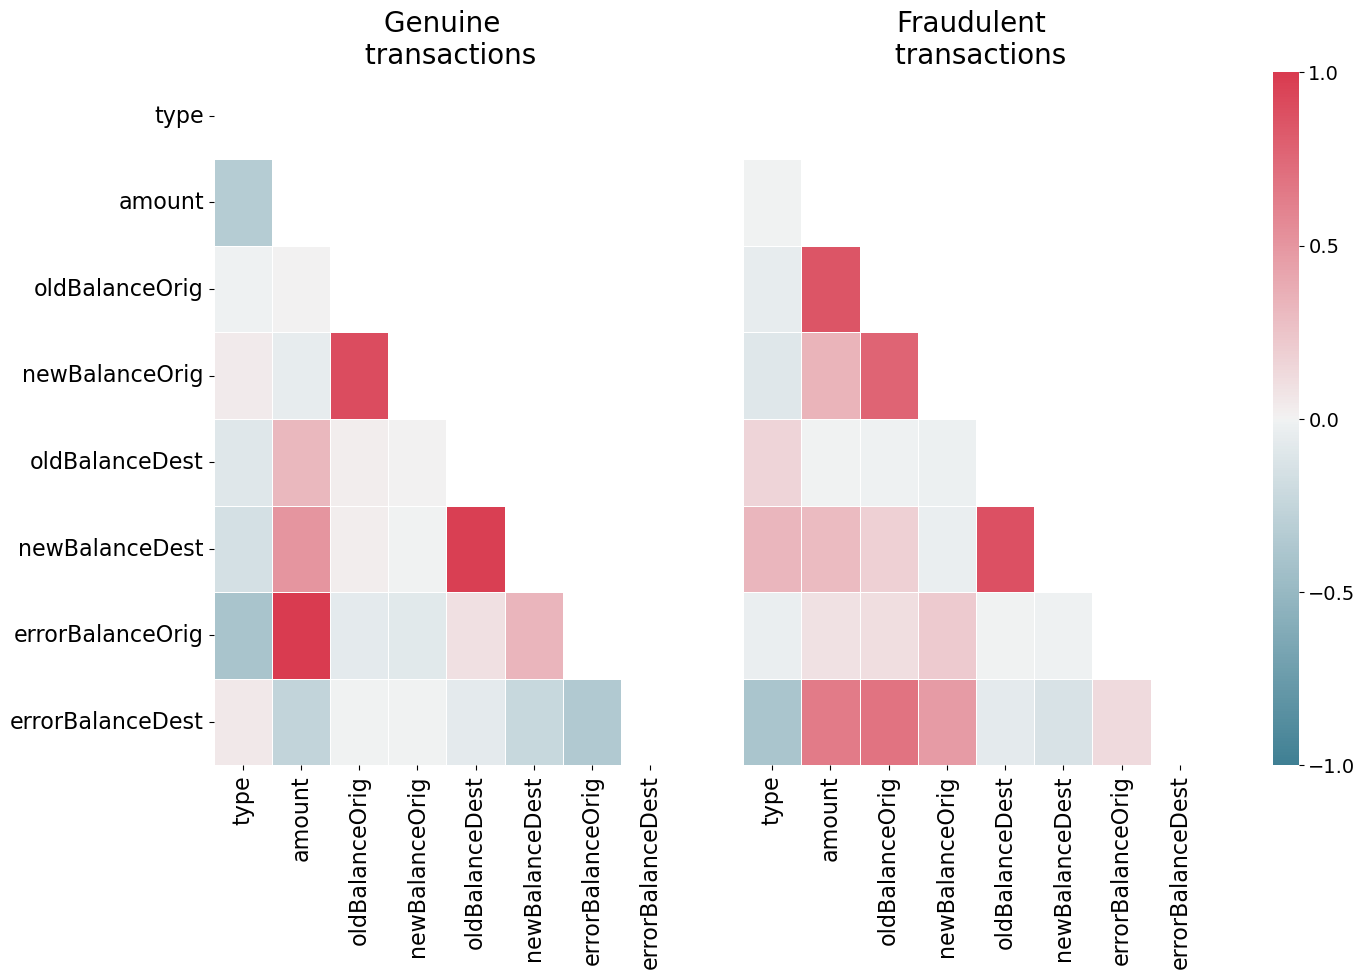

In [67]:
# Fingerprints of genuine and fraudulent transactions
# Update Xfraud and XnonFraud with cleaned data
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

# Compute correlation matrices
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()

# Define heatmap settings
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True
cmap = sns.diverging_palette(220, 8, as_cmap=True)
grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}

# Create figure and subplots
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize=(14, 9))

# Plot genuine transactions heatmap
ax1 = sns.heatmap(correlationNonFraud, ax=ax1, vmin=-1, vmax=1, cmap=cmap, square=False, linewidths=0.5, mask=mask, cbar=False)
ax1.set_xticklabels(ax1.get_xticklabels(), size=16)
ax1.set_yticklabels(ax1.get_yticklabels(), size=16)
ax1.set_title('Genuine \n transactions', size=20)

# Plot fraudulent transactions heatmap
ax2 = sns.heatmap(correlationFraud, ax=ax2, vmin=-1, vmax=1, cmap=cmap, square=False, linewidths=0.5, mask=mask, yticklabels=False, cbar_ax=cbar_ax, cbar_kws={'orientation': 'vertical', 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size=16)
ax2.set_title('Fraudulent \n transactions', size=20)

# Set colorbar label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size=14)

#### Building a classifier

In [68]:
# Split data 80:20 ratio
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = randomState)

In [69]:
# Calculate the weights for balancing classes in the model
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())

# Instantiate the XGBClassifier model with the given parameters
clf = XGBClassifier(max_depth=3, scale_pos_weight=weights, n_jobs=4)

# Fit the model on the training data and obtain the probabilities of predictions on the test data
probabilities = clf.fit(trainX, trainY).predict_proba(testX)

# Print the average precision score of the model
print('AUPRC = {}'.format(average_precision_score(testY, probabilities[:, 1])))

AUPRC = 0.9983642588456604


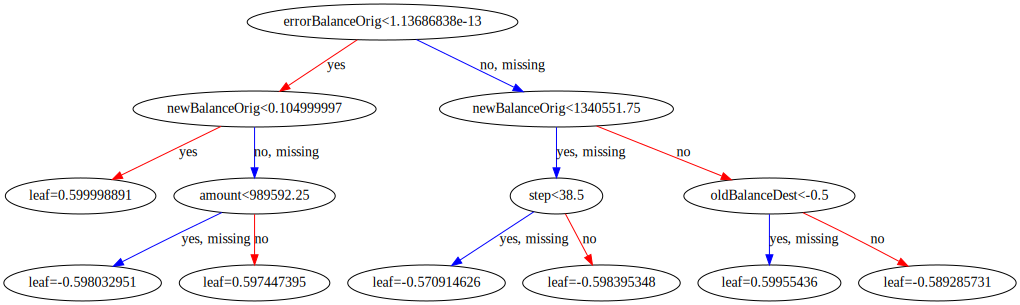

In [73]:
to_graphviz(clf)

AUPRC = 0.9983642588456604


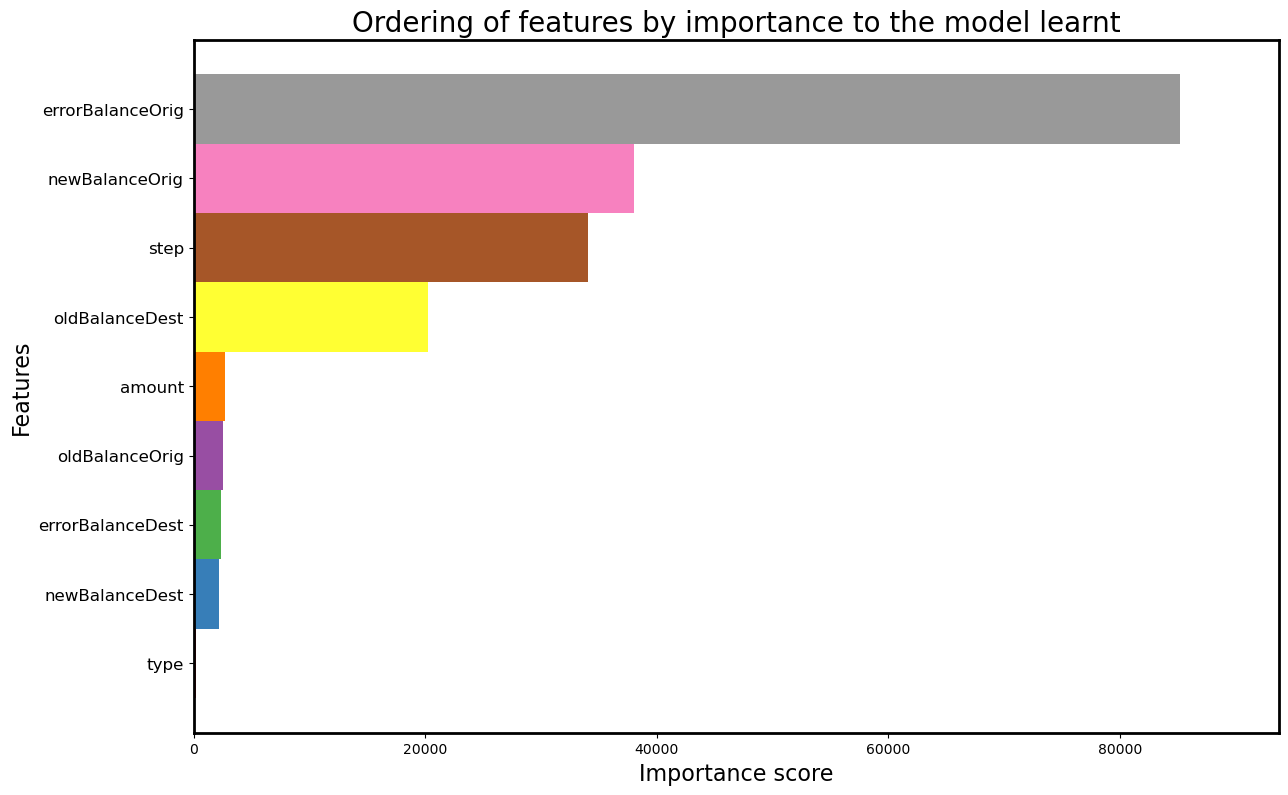

In [74]:
# Feature importance
importance_type = 'cover'
clf = XGBClassifier(max_depth=3, scale_pos_weight=weights, n_jobs=4)
clf.fit(trainX, trainY)

fig, ax = plt.subplots(figsize=(14, 9))
colors = plt.cm.Set1(np.linspace(0, 1, 9))

plot_importance(clf, ax=ax, height=1, color=colors, grid=False, show_values=False, importance_type=importance_type)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('Importance score', size=16)
ax.set_ylabel('Features', size=16)
ax.set_yticklabels(ax.get_yticklabels(), size=12)
ax.set_title('Ordering of features by importance to the model learnt', size=20)

probabilities = clf.predict_proba(testX)
auprc = average_precision_score(testY, probabilities[:, 1])
print(f"AUPRC = {auprc}")

In [ ]:
trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), trainX,\
                                         trainY, scoring = 'average_precision')

Text(0.5, 1.0, 'Learning curves')

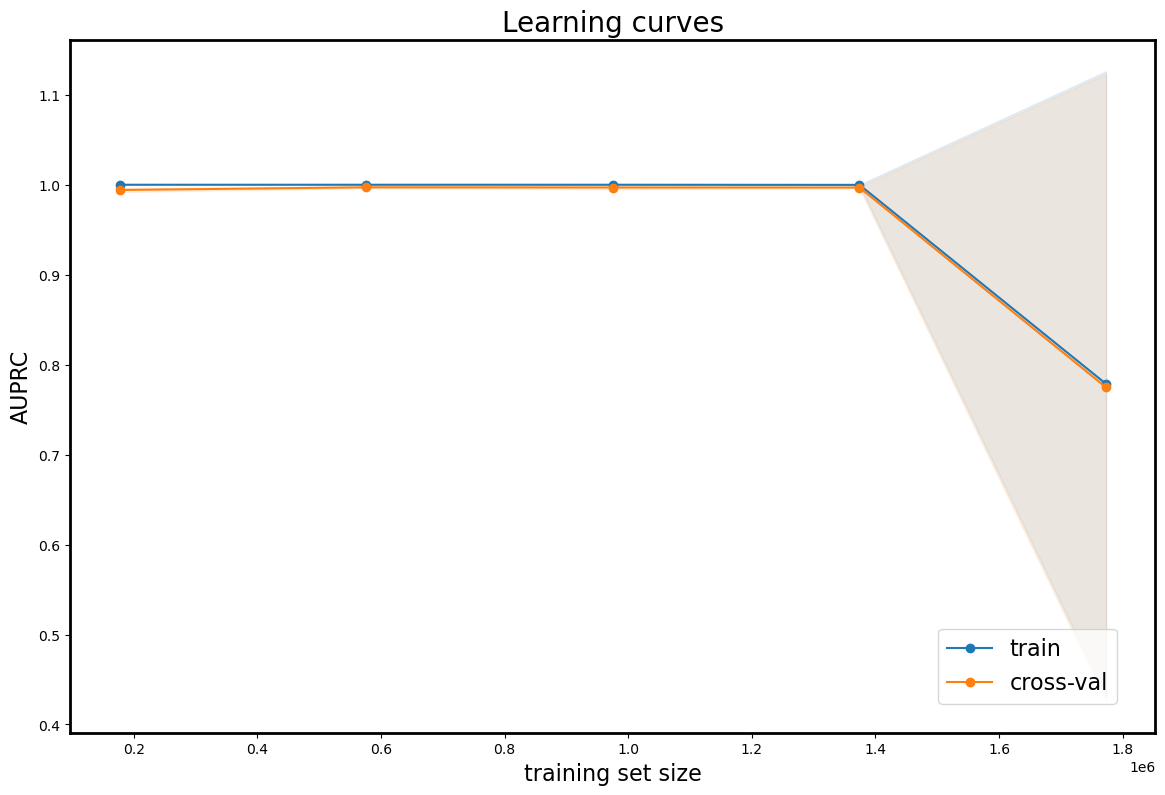

In [80]:
# Compute mean and standard deviation of scores
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

# Set colors for the plot
colours = plt.cm.tab10(np.linspace(0, 1, 9))

# Create a figure and set its size
fig = plt.figure(figsize=(14, 9))

# Fill in the area between the upper and lower bound of train and cross-validation scores
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd, trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd, crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])

# Plot the mean train and cross-validation scores with respect to training set size
plt.plot(trainSizes, trainScores.mean(axis=1), 'o-', label='train', color=colours[0])
plt.plot(trainSizes, crossValScores.mean(axis=1), 'o-', label='cross-val', color=colours[1])

# Set axis properties
ax = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

# Add legend, labels and title
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), loc=2, borderaxespad=0, fontsize=16)
plt.xlabel('training set size', size=16)
plt.ylabel('AUPRC', size=16)
plt.title('Learning curves', size=20)